In [2]:
from app.allocation import *
import matplotlib.pyplot as plt
from app.alloc_metric import *
from pprint import pprint
from collections import defaultdict 
import time
import json
import csv
import math

In [3]:
studentPref = "/mnt/c/Users/Ramon/Documents/Codes/FYP/backend/sample_data/prefs.csv"
ProjectInfo =  "/mnt/c/Users/Ramon/Documents/Codes/FYP/backend/sample_data/proj.csv"

with open(studentPref, mode="r", encoding="utf-8-sig") as infile:
    inputDict = csv.DictReader(infile)
    studentPreferences = createStudentPrefMap(inputDict)
with open(ProjectInfo, mode="r", encoding="utf-8-sig") as infile:
    inputDict = csv.DictReader(infile)
    StaffProjMap = createProjStaffMap(inputDict)
config = Config(defaultLoad = 10, maxDepth = 3)
studentProjectList = {
    student: [proj for proj, _ in projList]
    for student, projList in studentPreferences.items()
}
costMap = getCostMap(studentPreferences)
# alloc = bestAllocate(studentPreferences, StaffProjMap, config=config)


In [4]:
def showPopularity(pref):
    projectStudentMap = defaultdict(int)
    for _, l in pref.items():
        for p, l in l:
            projectStudentMap[p] += 10-l
    if projectStudentMap[0]: projectStudentMap.pop(0)
    return projectStudentMap

def showPopularityNum(pref):
    projectStudentMap = defaultdict(int)
    for _, l in pref.items():
        for p, l in l:
            projectStudentMap[p] += 1
    if projectStudentMap[0]: projectStudentMap.pop(0)
    return projectStudentMap

def showPopularityChoice(pref, choice):
    projectStudentMap = defaultdict(int)
    for _, l in pref.items():
        for p, l in l:
            if l == choice:
                projectStudentMap[p] += 1
    if projectStudentMap[0]: projectStudentMap.pop(0)
    return projectStudentMap


def staffPopularity(pref, projStaff):
    projectMap = showPopularity(pref)
    out = defaultdict(int)
    for k, v in projectMap.items():
        out[projStaff.get(k, 0)] += v
    return out

def getEqualChoice(studentPref):
    res = defaultdict(int)
    for s, prefs in studentPref.items():
        for (cProj, cRank), (nProj, nRank) in zip(prefs, prefs[1:]):
                res[cRank] += 1
    return res

def getStudentNumChoice(studentPref):
    return {s: len([v for a,v in p if a != 0]) for s, p in studentPref.items()}

def getStaffLoading(projStaff):
    out = defaultdict(int)
    for p, s in projStaff.items():
        out[s]+=1
    return out
# staffPopularity(pref2, staff)

In [5]:
import math
import numpy as np
def createMockData(noStudent, tightness, stafftightness, num_choices, minStaff, ratioProjectStaff, ratioStudentGeneral, equalCloseness, scale):
    noProject = math.ceil(noStudent * tightness)
    noStaff = math.ceil((noProject*stafftightness)/minStaff)
    print(f'project: {noProject} staff:{noStaff}')
    projectPop = [np.random.normal(scale=1.0) for i in range(noProject)]
    staffPop =   [np.random.normal(scale=ratioProjectStaff) for i in range(noStaff)]
    staffLoadInit = [abs(np.random.normal()) for i in range(noStaff)]
    staffLoad = [float(i)/sum(staffLoadInit) for i in staffLoadInit]
    # staffProjMap = {i+1:j.item() for i, j in enumerate(np.repeat(np.arange(1, noStaff+1), load))}
    staffProjMap = {}
    j = 1
    for s, l in enumerate(staffLoad):
        for i in range(math.ceil(l*noProject)):
            if len(staffProjMap) >= noProject:
                break
            staffProjMap[j] = s+1
            j += 1
    studentPreferences = defaultdict(list)
    for i in range(noStudent):
        projectFit = [ratioStudentGeneral*np.random.normal(scale=1.0) for i in range(len(projectPop))]
        staffFit = [ratioStudentGeneral*np.random.normal(scale=ratioProjectStaff) for i in range(len(staffPop))]
        totalStaffPref = np.add(staffPop, staffFit)
        totalProjPref = np.add(projectPop, projectFit)
        # print(totalStaffPref[staffProjMap[i+1]])
        finalPref = np.add(totalProjPref, [totalStaffPref[staffProjMap[i+1]] for i in range(noProject)])
        finalPref = np.array([x/sum(finalPref) for x in finalPref])
        selectedProject = np.argsort(-finalPref)[:num_choices]
        studentPreferences[i] += [(selectedProject[0].item()+1, 1)]
        rank = 1
        for j, (proj, prev_proj) in enumerate(zip(selectedProject[1:], selectedProject)):
            x = random.random()
            rank = rank if scale*math.exp(-x*equalCloseness) > j+1 else j+2
            studentPreferences[i] += [((proj.item()+1), rank)]
            if len({staffProjMap[b] for b, _ in studentPreferences[i]}) >= minStaff:
                break
    return studentPreferences, staffProjMap
# yeet = createMockData(100, 2, 5, 10, 1, 1, 0.002, 1)


In [6]:
def callback():
    i = 0
    while True:
        a = yield
        if i % 100 == 0:
            print(a)
        i += 1

In [117]:
stat_runs = defaultdict(list)
for t in [20,40,50,75,100,125,150]:
    for _ in range(5):
        a, b = createMockData(t, 1.5, 1.5, 10, 3, 1.4, 1.24 ,3, 8)
        output, cs = bestAllocateAllResults(a, b, config=Config(maxDepth=5, numRuns=500))
        cover = checkConverage(cs)
        stat_runs[t] += [cover]
        print(cover)



project: 30 staff:15
2
project: 30 staff:15
3
project: 30 staff:15
2
project: 30 staff:15
3
project: 30 staff:15
2
project: 60 staff:30
14
project: 60 staff:30
12
project: 60 staff:30
2
project: 60 staff:30
11
project: 60 staff:30
12
project: 75 staff:38
5
project: 75 staff:38
3
project: 75 staff:38
14
project: 75 staff:38
10
project: 75 staff:38
125
project: 113 staff:57
63
project: 113 staff:57
5
project: 113 staff:57
20
project: 113 staff:57
39
project: 113 staff:57
-1
project: 150 staff:75
-1
project: 150 staff:75
3
project: 150 staff:75
6
project: 150 staff:75
5
project: 150 staff:75
36
project: 188 staff:94
-1
project: 188 staff:94
12
project: 188 staff:94
72
project: 188 staff:94
2
project: 188 staff:94
6
project: 225 staff:113
59
project: 225 staff:113
-1
project: 225 staff:113
21
project: 225 staff:113
134
project: 225 staff:113
9


In [20]:
print(stat_dict)

defaultdict(<class 'list'>, {15: [(3, 2), (4, 18), (3, 2), (3, 2), (4, 2)], 20: [(4, 5), (6, 300), (4, 14), (4, 5), (4, 45)], 40: [(4, 16), (4, 2), (6, 300), (5, 4), (4, 5)], 50: [(14, 300), (5, 5), (4, 3), (5, 10), (5, 3)], 75: [(6, 75), (4, 2), (5, 11), (5, 15), (7, 300)], 100: [(7, 12), (5, 6), (6, 14), (12, 269), (4, 2)], 125: [(6, 4), (5, 38), (5, 48), (8, 300), (5, 7)], 150: [(9, 58), (5, 4)]})


In [115]:
for k, v in stat_dict.items():
    depthL = [a for a,_ in v]
    numRunsL = [a for _,a in v]
    print(k, mean(numRunsL))

15 5.2
20 73.8
40 65.4
50 64.2
75 80.6
100 60.6
125 79.4
150 31


0.30803593627659803 0.43364003469368506


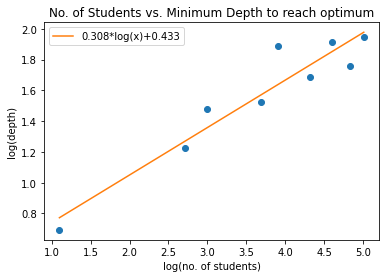

In [118]:
x = np.array([3,15,20,40,50,75,100,125,150])
y = np.array([2,3.4,4.4,4.6,6.6,5.4,6.8,5.8,7])
y2 = np.array([2,4,6,6,14,7,12,8,9])
b, c = np.polyfit(np.log(x), np.log(y),1)
plt.plot(np.log(x), np.log(y), 'o')
print(b,c)
b_r = round(b,3)
c_r = round(c,3)
plt.plot(np.log(x), b_r*np.log(x) + c_r, label='0.308*log(x)+0.433')
plt.xlabel('log(no. of students)')
plt.ylabel('log(depth)')
plt.title('No. of Students vs. Minimum Depth to reach optimum')
plt.legend()
math.exp(b*math.log(133)+c)
plt.savefig('depthGraph.pdf')


project: 76 staff:285


(array([74.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
 array([1. , 1.7, 2.4, 3.1, 3.8, 4.5, 5.2, 5.9, 6.6, 7.3, 8. ]),
 <BarContainer object of 10 artists>)

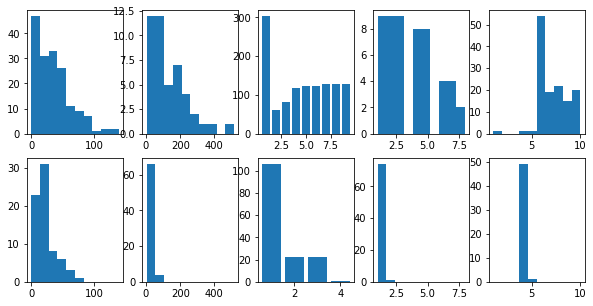

In [12]:
fig, axes = plt.subplots(2, 5, figsize=(10,5))
pref2, staff = createMockData(50, 200/133, 15, 10, 4, 1.4, 2 , 3.2,8)
pop = showPopularity(studentPreferences)
_, bins, _ = axes[0][0].hist(pop.values())
pop2 = showPopularity(pref2)
axes[1][0].hist(pop2.values(), bins=bins)

pop = staffPopularity(studentPreferences, StaffProjMap)
_, bins, _ =  axes[0][1].hist(pop.values())
pop2 = staffPopularity(pref2, staff)
axes[1][1].hist(pop2.values(), bins=bins)

equalChoices_mock = getEqualChoice(pref2)
equalChoices_actual = getEqualChoice(studentPreferences)

axes[0][2].bar(equalChoices_actual.keys(), equalChoices_actual.values())
axes[1][2].bar(equalChoices_mock.keys(), equalChoices_mock.values())

numChoices_mock = getStudentNumChoice(pref2)
numChoices_actual = getStudentNumChoice(studentPreferences)
_, bins, _ = axes[0][4].hist(numChoices_actual.values())
axes[1][4].hist(numChoices_mock.values(), bins=bins)

s1 = getStaffLoading(StaffProjMap)
_, bins, _ =  axes[0][3].hist(s1.values())
s2 = getStaffLoading(staff)
axes[1][3].hist(s2.values(), bins=bins)


-1

In [14]:
result = bestAllocate(studentPreferences, StaffProjMap,  config=Config(numRuns=10, maxDepth=5))
getStat(result, getCostMap(studentPreferences), StaffProjMap)

{'MaxRank': 7,
 'MedianRank': 1,
 'AvgRank': 1.5639097744360901,
 'AvgRankNoUnalloc': 1.5639097744360901,
 'VarianceRank': 1.7346373452428063,
 'MaxLoad': 5,
 'MedianLoad': 3,
 'VarLoad': 2.2058298631766804,
 'NoUnfair': 27,
 'MagUnfair': 45,
 'AveUnfair': 0.3383458646616541,
 'NoUnalloc': 0}

In [17]:
with open('./evaluations/mockdata/50students/prefs.json', 'w') as pref_f:
    json.dump(pref2, pref_f)
with open('./evaluations/mockdata/50students/proj.json', 'w') as staff_f:
    json.dump(staff, staff_f)

In [19]:
print(staff)osecondsecondsthriirdteasyeasy

SyntaxError: invalid syntax (<ipython-input-19-01be0402c112>, line 1)

In [28]:
print(StaffProjMap)
for proj, staff in StaffProjMap.items():
    res[staff] 

{1801604: 8, 1801605: 8, 1801641: 8, 1801642: 8, 1801663: 8, 1801678: 8, 1801679: 8, 1801379: 30, 1801380: 30, 1801383: 30, 1801621: 30, 1801686: 10, 1801687: 10, 1801658: 45, 1801659: 45, 1801660: 45, 1801662: 45, 1801759: 1, 1801761: 1, 1801472: 20, 1801477: 20, 1801478: 20, 1801572: 20, 1801639: 20, 1801751: 20, 1801499: 43, 1801500: 43, 1801657: 43, 1801630: 48, 1801631: 48, 1801632: 48, 1801633: 48, 1801634: 48, 1801801: 48, 1801613: 13, 1801614: 13, 1801615: 13, 1801618: 13, 1801773: 13, 1801774: 13, 1801775: 13, 1801799: 13, 1801625: 31, 1801626: 31, 1801627: 31, 1801628: 31, 1801643: 6, 1801644: 6, 1801645: 6, 1801646: 6, 1801647: 6, 1801680: 40, 1801681: 40, 1801682: 40, 1801541: 41, 1801749: 41, 1801750: 41, 1801454: 44, 1801455: 44, 1801683: 44, 1801684: 44, 1801685: 44, 1801730: 44, 1801731: 44, 1801654: 53, 1801655: 53, 1801656: 53, 1801797: 53, 1801740: 49, 1801741: 49, 1801743: 49, 1801707: 38, 1801708: 38, 1801709: 38, 1801712: 38, 1801692: 24, 1801693: 24, 1801694: 24,

In [85]:
import statistics as stat

# (min(.values()) + max(getStaffLoading(StaffProjMap).values()))/2

stat.quantiles(getStudentNumChoice(studentPreferences).values(), n=4)[1]

7.0

In [4]:

{k: v for k, v in sorted(x.items(), key=lambda item: item[1])}

2.462962962962963

In [27]:
x = showPopularityNum(studentPreferences)


for k, v in studentPreferences.items():
    for p, c in v:
        if p == 1801645:
            print(k,c)

90395 4


In [55]:
len(getStaffLoading(StaffProjMap))

54